# Generate feasible prufer sequences ------ (Wang)

In [2]:
#check if a solution is feasible
def checkSolution(sol, m , n):
  freq = [0] * (m + n + 1)
  for x in sol:
    freq[x] += 1
  ts = 0
  td = 0
  for i in range(1, m + n + 1):
    if i <= m:
      ts += freq[i] + 1
    else:
      td += freq[i] + 1
  return ts - td

#transfer a random soluiton to a feasible solution
def repair(sol, m, n):
  tmp = checkSolution(sol, m, n)
  while tmp != 0:
    r = random.randrange(n + m - 2)
    if tmp < 0:
      sol[r] = (sol[r] % m) + 1
    else:
      sol[r] = (sol[r] % n) + 1 + m
    tmp = checkSolution(sol, m, n)
  return sol

#create a feasible solution
def createSolution(m, n):
    sol = []
    for i in range(n + m - 2):
      sol.append(random.randrange(1, n + m + 1))
    sol = repair(sol, m, n)
    return sol

In [6]:
#transfer to spantree from prufer
def tranferToTree(prufer, m, n):
  edges = []
  p = prufer.copy()
  g = []
  for i in range(1, m + n + 1):
    g.append(i)
  while (len(g) > 2):
    for i in range(len(g)):
      if g[i] not in p:
        edges.append((min(p[0], g[i]), max(p[0], g[i])))
        del p[0]
        del g[i]
        break
  edges.append((min(g[0], g[1]), max(g[0], g[1])))
  return edges


In [7]:
prufer = [1,7,5,3,8,2,4]
edges = tranferToTree(prufer, 4, 5)
print(edges)

[(1, 6), (1, 7), (5, 7), (3, 5), (3, 8), (2, 8), (2, 4), (4, 9)]


# St-GA ---(Yuan)

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from collections import deque
import networkx as nx
from tqdm import tqdm
from collections import defaultdict
import time



### Modified feasible prufer sequences generation 

In [3]:
def createSolution(m, n):
    sequence1 = [random.randint(1, m) for _ in range(n-1)]
    sequence2 = [random.randint(m+1, n+m) for _ in range(m-1)]
    
    # Insert numbers from sequence2 into sequence1
    for num in sequence2:
        position = random.randint(0, len(sequence1))
        sequence1.insert(position, num)
    
    return sequence1

### Convert prufer sequences to transportation tree

In [4]:
def prufer_to_tree(graph, prefer_sequence, m, n):
    num_nodes = m + n
    # Nodes eligible for consideration
    eligible_nodes = deque(sorted(set(range(1, num_nodes + 1)) - set(prefer_sequence)))

    # Dictionary for availability of each node
    avail = {i: graph[i-1] for i in range(1, num_nodes + 1)}

    tree = []
    # Step 2: Repeat the following process – (2.1)–(2.5) – until no digits are left in P(T).
    while prefer_sequence:
        # 2.1 Let i be the lowest numbered eligible node in Q(T). Let j be the leftmost digit of P(T)
        i = eligible_nodes[0]
        j = prefer_sequence[0]

        # 2.2 If i and j are not in the same set O or D, add the edge (i, j) to tree T.
        if (i <= m and j <= m) or (i > m and j > m):
            # Otherwise, select the next digit k from P(T) that is not included in the same set with i,
            # exchange j with k, and add the edge (i, k) to the tree T.
            k = next((k for k in prefer_sequence if (i <= m and k > m) or (i > m and k <= m)), None)
            if k:
                prefer_sequence.remove(k)
                #tree.append((i, k))

                # 2.4 Assign the available amount of values to xik = min{ai, bk}
                xik = min(avail[i], avail[k])
                
                # Include the value xik in the edge information
                tree.append((min(i,k), max(i,k), xik))
                
                # 2.5 Update availability ai = ai − xik and bk = bk − xik
                avail[i] -= xik
                avail[k] -= xik

                # 2.3 Remove j (or k) from P(T) and i from Q(T).
                eligible_nodes.remove(i)
                if k not in prefer_sequence:
                    eligible_nodes.append(k)
                eligible_nodes = deque(sorted(eligible_nodes))
        else:
            prefer_sequence.remove(j)
            #tree.append((i, j))
            
            # 2.4 Assign the available amount of values to xij = min{ai, bj}
            xij = min(avail[i], avail[j])
            
            # Include the value xik in the edge information
            tree.append((min(i,j), max(i,j), xij))
            
            # 2.5 Update availability ai = ai − xij and bj = bj − xij
            avail[i] -= xij
            avail[j] -= xij

            # 2.3 Remove j (or k) from P(T) and i from Q(T).
            eligible_nodes.remove(i)
            if j not in prefer_sequence:
                eligible_nodes.append(j)
            eligible_nodes = deque(sorted(eligible_nodes))

    # Step 3: If no digits remain in P(T) then there are exactly two nodes, i and j, still eligible in Q(T)
    # for consideration. Add edge (i, j) to tree T and form a tree with m + n − 1 edges.
    #if len(eligible_nodes) == 2:
        # The remaining edge has the remaining values of the nodes as its value
    #    tree.append((eligible_nodes[0], eligible_nodes[1], min(avail[eligible_nodes[0]], avail[eligible_nodes[1]])))

    # Step 4: If there are no available units to assign, then stop.
    remaining_avail = {k: v for k, v in avail.items() if v > 0}

    if not remaining_avail:
        return tree
    while remaining_avail:
        # Otherwise, there are supply r and demand s remaining.
        r, s = None, None
        for node, avail_units in remaining_avail.items():
            if node <= m and not r:  # supply nodes
                r = node
            elif node > m and not s:  # demand nodes
                s = node
            if r and s:
                break

        # Add the edge (r, s) to the tree and assign the available amount xrs = ar = bs to the edge.
        xrs = min(remaining_avail[r], remaining_avail[s])
        tree.append((min(r, s), max(r, s), xrs))

        # Update availability ar = ar − xrs and bs = bs − xrs
        avail[r] -= xrs
        avail[s] -= xrs
        remaining_avail = {k: v for k, v in avail.items() if v > 0}
    # If a cycle exists, remove he edge that is assigned zero flow. A new spanning tree is formed with m + n − 1 edges.
    tree = [(node1, node2, value) for node1, node2, value in tree if value > 0]

    return tree


In [5]:
def draw_tree(tree):
    # Create a directed graph
    G = nx.DiGraph()

    # Add the edges to the graph
    for edge in tree:
        G.add_edge(edge[0], edge[1], weight=edge[2])
    # Draw the graph
    pos = nx.circular_layout(G)  # compute a layout for the nodes
    nx.draw_networkx(G, pos, with_labels=True)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

### Test 1 --- The example from the current paper

In [6]:
graph = [8,19,17,11,3,14,16]
prefer_sequence = [4, 2, 2, 7, 3]
m = 3
n = 4

tree = prufer_to_tree(graph, prefer_sequence, m, n)
print(tree)

[(1, 4, 8), (2, 4, 3), (2, 5, 3), (2, 7, 13), (3, 6, 14), (3, 7, 3)]


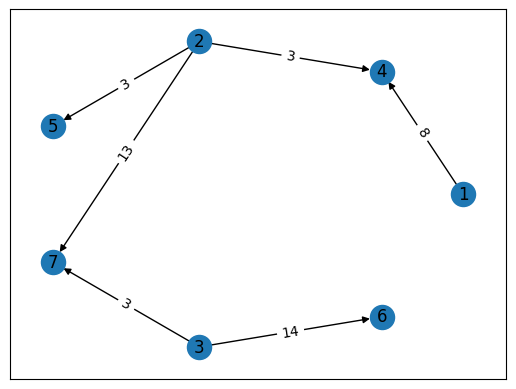

In [7]:
draw_tree(tree)

### Counter exmaple for prufer to tree

In [8]:
graph = [11,19,17,7,4,16,10,16,8]
prefer_sequence = [1,7,5,3,8,2,4]
m = 4
n = 5

tree = prufer_to_tree(graph, prefer_sequence, m, n)
print(tree)

[(1, 6, 11), (3, 7, 10), (3, 5, 4), (2, 8, 16), (2, 6, 3), (3, 6, 2), (3, 9, 1), (4, 9, 7)]


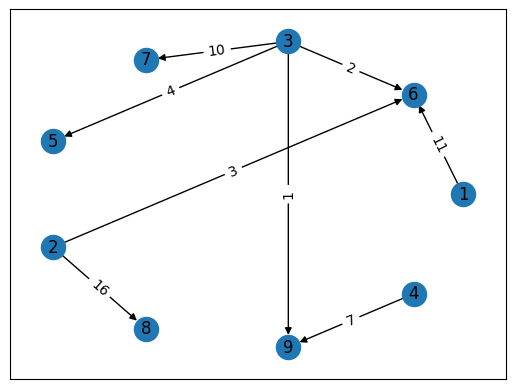

In [9]:
draw_tree(tree)

### Cost function

In [10]:
def cost_function(m, n, tree, c, d):

        x = [[0] * n for _ in range(m)]  # Initialize the decision variable matrix

        # Assign the ship values from the edges to the decision variable matrix
        for edge in tree:
            i, j, ship_value = edge     
            x[i-1][j-m-1] = ship_value

        total_cost = 0

        # Calculate the total variable cost and fixed cost
        for i in range(m):
            for j in range(n):
                variable_cost = c[i][j] * x[i][j] * x[i][j]  # Variable cost term fij(x)
                fixed_cost = d[i][j] * (x[i][j] > 0)  # Fixed cost term dij * gij(x)
                total_cost += variable_cost + fixed_cost

        return total_cost
 

### Fitness function

In [11]:
def fitness(graph, prefer_sequence, m, n, c, d):
    sol = prefer_sequence.copy()
    tree = prufer_to_tree(graph, sol, m, n)
    score = 1/(cost_function(m, n, tree, c, d))
    return score



### Crossover

In [12]:
def crossover(parent1, parent2,m,n):
    """One cut point crossover"""
    try:
    # Create empty offspring
        offspring1 = []
        offspring2 = []

        # Select a random cut point
        cut_point = random.randint(1, len(parent1) - 1)

        # Perform crossover
        offspring1.extend(parent1[:cut_point] + parent2[cut_point:])
        offspring2.extend(parent2[:cut_point] + parent1[cut_point:])
        
        # Repair offsprings
        offspring1 = repair(offspring1, m, n)
        offspring2 = repair(offspring1, m, n)
        return offspring1, offspring2

    except:
        print(parent1,parent2)

### Mutation

In [13]:
def inversion_mutation(offspring):
    # Select two random positions within the offspring chromosome
    pos1, pos2 = np.random.choice(len(offspring), size=2, replace=False)

    pos1, pos2 = min(pos1, pos2), max(pos1, pos2)

    # Invert the substring between pos1 and pos2
    mutated_offspring = offspring.copy()
    mutated_offspring[pos1:pos2+1] = offspring[pos1:pos2+1][::-1]

    return mutated_offspring


def displacement_mutation(offspring):
    # Select a random substring within the offspring chromosome
    start, end = np.random.choice(len(offspring), size=2, replace=False)
    start,end = min(start, end),max(start, end)
    substring = offspring[start:end+1]

    # Remove the substring from the offspring chromosome
    mutated_offspring = offspring[:start] + offspring[end+1:]

    # Insert the substring in a random position
    insertion_point = random.randint(0, len(mutated_offspring))
    mutated_offspring = mutated_offspring[:insertion_point] + substring + mutated_offspring[insertion_point:]

    return mutated_offspring


def mutation_selector(offspring):
    # Randomly select a mutation operation based on the mutation probability
    if random.random() < 0.51:

        return inversion_mutation(offspring)
    else:

        return displacement_mutation(offspring)


### Selection 

In [14]:
def roulette_wheel(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    selection_probs = [score/total_fitness for score in fitness_scores]

    # select individuals using selection probabilities
    chromosome = random.choices(population, weights=selection_probs, k=1)[0]
        
    return chromosome


In [15]:
def selection(parents, offsprings, population_size,graph,m,n,c,d):
    # Combine parents and offsprings
    combined = parents + offsprings
    
    # Calculate fitness of each individual in the population
    new_fitness_scores = [fitness(graph, individual, m, n, c, d,) for individual in combined]
    
    # Use roulette_wheel select population size new generation
    new_generation = []
    for _ in range(population_size):
        chromosome = roulette_wheel(combined, new_fitness_scores)
        new_generation.append(chromosome)
    
    return new_generation


### Genetic Algorithm (GA)

In [16]:
def genetic_algorithm(population_size, max_iteration, mutation_rate, crossover_rate, m, n, c, d, graph):
    # Generate initial population
    population = [createSolution(m, n) for _ in range(population_size)]

    # Calculate fitness of each individual in the population
    fitness_scores = [fitness(graph, individual, m, n, c, d,) for individual in population]
    
    # Store best solution
    best_fitness = min(fitness_scores)
    best_solution = population[fitness_scores.index(best_fitness)]
    
    # Create arrays to store the best fitness and average fitness at each iteration
    bestFitnessList = [best_fitness]
    avgFitnessList = [np.mean(fitness_scores)]

    # Main loop for GA
    for iteration in range(max_iteration):
 
        # Initialize the offsprings
        offsprings = []
        
        for i in range(population_size):
            
            # Selection of parents
            parent1 = roulette_wheel(population, fitness_scores)
            parent2 = roulette_wheel(population, fitness_scores)
        
            # Crossover 
            if random.random() < crossover_rate:
                offspring1, offspring2 = crossover(parent1, parent2,m,n)
            else:
                offspring1, offspring2 = parent1, parent2
        
            # Mutation
            if random.random() < mutation_rate:
                offspring1 = mutation_selector(offspring1)
                offspring2 = mutation_selector(offspring2)
        
            # Store the offsprings  
            offsprings.append(offspring1)
            offsprings.append(offspring2)

        # Selection for the next generation
        population = selection(population, offsprings, population_size,graph,m,n,c,d)

        # Update best solution
        fitness_scores = [fitness(graph, individual, m, n, c, d) for individual in population]

        current_best_fitness = max(fitness_scores)

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[fitness_scores.index(best_fitness)]
        
        #print(f'iteration {iteration}: The best fitness = {best_fitness}, The best solution = {best_solution}')
        
        # Store the best fitness and average fitness at each iteration
        bestFitnessList.append(best_fitness)
        avgFitnessList.append(np.mean(fitness_scores))
    
    return best_solution,bestFitnessList,avgFitnessList


### Results

### 4*5 problem in the paper

In [17]:
# Shipping cost
c1 = [[8,4,3,5,8],[3,6,4,8,5],[8,4,5,3,4],[4,6,8,3,3]] 

# Fixed cost
d1 = [[60,88,95,76,97],[51,72,65,87,76],[67,89,99,89,100],[86,84,70,92,88]]

# Graph of supply and demand
graph1 = [57,93,50,75,88,57,24,73,33]


In [18]:
population_size = 100
max_iteration = 500
mutation_rate = 0.4
crossover_rate = 0.2
m = 4
n = 5
c = c1
d = d1
graph = graph1

In [19]:
start_time = time.time()
best_solution,bestFitnessList,avgFitnessList = genetic_algorithm(population_size, max_iteration, mutation_rate, crossover_rate, m, n, c, d, graph)
end_time = time.time()
print("Running time: {:.2f}seconds".format(end_time - start_time))   

Running time: 12.00seconds


In [20]:
best_solution

[6, 1, 8, 3, 5, 4, 2]

In [21]:
tree = prufer_to_tree(graph, best_solution, m, n)
bestcost = (cost_function(m, n, tree, c, d))
bestcost

37090

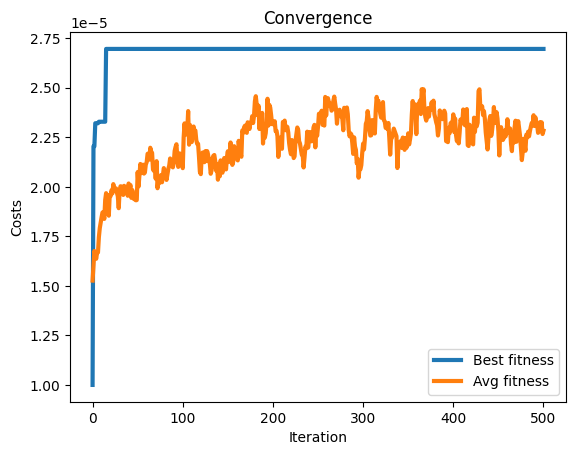

In [22]:
# Plot the result
plt.plot(bestFitnessList, linewidth = 3, label = "Best fitness")
plt.plot(avgFitnessList, linewidth = 3, label = "Avg fitness")
plt.title("Convergence")
plt.xlabel("Iteration")
plt.ylabel('Costs')
plt.legend()
plt.show()

### 5*10 problem in the paper

In [23]:
# Shipping cost
c2= [[8,4,3,5,2,1,3,5,2,6],[3,3,4,8,5,3,5,1,4,5],[7,4,5,3,4,2,4,3,7,3],[1,2,8,1,3,1,4,6,8,2],[4,5,6,3,3,4,2,1,2,1]]

# Fixed cost
d2 = [[160,488,295,376,297,360,199,292,481,162],[451,172,265,487,176,260,280,300,354,201],[167,250,499,189,340,216,177,495,170,414],[386,184,370,292,188,206,340,205,465,273],[156,244,460,382,270,180,235,355,276,190]]

# Graph of supply and demand
graph2 = [157,293,150,575,310,225,150,90,215,130,88,57,124,273,133]



In [24]:
population_size = 100
max_iteration = 1000
mutation_rate = 0.4
crossover_rate = 0.2
m = 5
n = 10
c = c2
d = d2
graph = graph2

In [25]:
start_time = time.time()
best_solution,bestFitnessList,avgFitnessList = genetic_algorithm(population_size, max_iteration, mutation_rate, crossover_rate, m, n, c, d, graph)
end_time = time.time()
print("Running time: {:.2f}seconds".format(end_time - start_time)) 


Running time: 39.64seconds


In [26]:
best_solution

[4, 12, 2, 4, 3, 1, 6, 6, 2, 3, 1, 1, 10]

In [27]:
tree = prufer_to_tree(graph, best_solution, m, n)
bestcost = (cost_function(m, n, tree, c, d))
bestcost

313368

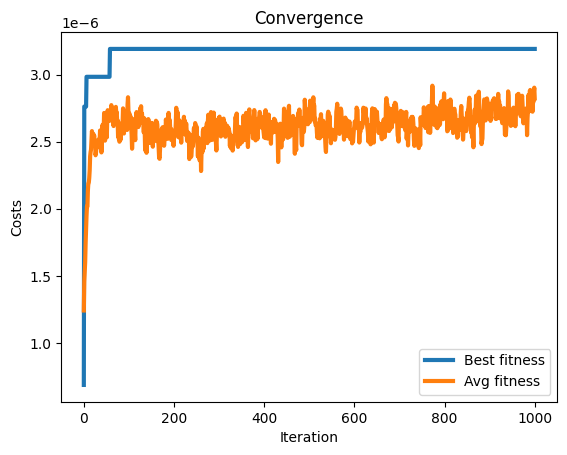

In [28]:
# Plot the result
plt.plot(bestFitnessList, linewidth = 3, label = "Best fitness")
plt.plot(avgFitnessList, linewidth = 3, label = "Avg fitness")
plt.title("Convergence")
plt.xlabel("Iteration")
plt.ylabel('Costs')
plt.legend()
plt.show()

# Pb-GA --- (Sheikh)

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def calculate_total_cost(allocation):
    total_cost = 0
    for i in range(num_sources):
        for j in range(num_destinations):
            variable_cost = allocation[i][j] * allocation[i][j] * variable_costs[i][j]  # Variable cost per unit
            gij = 1 if allocation[i][j] > 0 else 0  # Indicator function
            fixed_cost = fixed_costs[i][j]  # Fixed cost
            total_cost += variable_cost + fixed_cost * gij
    return total_cost

def fitness_evaluation(population):
    total_costs = np.zeros(population.shape[0])
    for i in range(population.shape[0]):
        total_costs[i] = calculate_total_cost(population[i])
    return 1 / (total_costs + 1e-6)    # Add a small epsilon value to avoid division by zero




In [ ]:
def priority_selection(fitness_values):
    sorted_indices = np.argsort(fitness_values)
    priority_values = np.arange(population_size)
    return priority_values[sorted_indices]

def crossover(population, priority_values):
    elite_size = int(elite_percentage * population_size)
    elites = population[np.argsort(priority_values)[:elite_size]]

    priority_sum = np.sum(priority_values)
    probabilities = priority_values / priority_sum

    parent_indices = np.random.choice(population_size, size=(population_size - elite_size, 2), p=probabilities)
    parents1 = population[parent_indices[:, 0]]
    parents2 = population[parent_indices[:, 1]]
    offspring = np.where(np.random.rand(population_size - elite_size, num_sources, num_destinations) < 0.5,
                         parents1, parents2)

    return np.concatenate((elites, offspring))

def mutation(offspring):
    for i in range(offspring.shape[0]):
        remaining_supply = np.copy(supply)
        for j in range(num_destinations):
            for k in range(num_sources):
                remaining_supply[k] -= offspring[i, k, j]
        for k in range(num_sources):
            while remaining_supply[k] > 0:
                possible_destinations = np.where(demand > offspring[i, k])
                if len(possible_destinations[0]) == 0:
                    break
                dest_index = np.random.choice(possible_destinations[0])
                max_allocation = min(remaining_supply[k], demand[dest_index] - offspring[i, k, dest_index])
                allocation = np.random.randint(low=0, high=max_allocation + 1)
                offspring[i, k, dest_index] += allocation
                remaining_supply[k] -= allocation
    return offspring

def replacement(population, offspring, fitness_values):
    sorted_indices = np.argsort(fitness_values)
    num_replaced = population_size - int(elite_percentage * population_size)
    population[sorted_indices[:num_replaced]] = offspring[:num_replaced]
    return population

In [ ]:
# Problem parameters
num_sources = 4
num_destinations = 5
variable_costs = np.array([[8, 4, 3, 5, 8], [3, 6, 4, 8, 5], [8, 4, 5, 3, 4], [4, 6, 8, 3, 3]])  # variable cost matrix
fixed_costs = np.array([[60, 88, 95, 76, 97], [51, 72, 65, 87, 76], [67, 89, 99, 89, 100], [86, 84, 70, 92, 88]])  # fixed cost matrix
supply = np.array([57, 93, 50, 75])
demand = np.array([88, 57, 24, 73, 33])

# Genetic algorithm parameters
population_size = 100
num_generations = 500
mutation_rate = 0.4
elite_percentage = 0.2

# Initialize population
population = np.zeros((population_size, num_sources, num_destinations))
for i in range(population_size):
    remaining_supply = np.copy(supply)
    for j in range(num_destinations):
        for k in range(num_sources):
            max_allocation = min(remaining_supply[k], demand[j])
            population[i, k, j] = np.random.randint(low=0, high=max_allocation + 1)
            remaining_supply[k] -= population[i, k, j]



# Main loop
progress_bar = tqdm(total=num_generations, desc="Generations")
best_costs = []
worst_costs = []
average_costs = []
best_val = []

for generation in range(num_generations):
    fitness_values = fitness_evaluation(population)
    priority_values = priority_selection(fitness_values)
    offspring = crossover(population, priority_values)
    offspring = mutation(offspring)
    population = replacement(population, offspring, fitness_values)

    # Find the best solution
    best_solution_index = np.argmax(fitness_values)
    best_solution = population[best_solution_index]
    best_total_cost = calculate_total_cost(best_solution)

    best_val.append(best_total_cost)
    best_costs.append(np.max(fitness_values))
    worst_costs.append(np.min(fitness_values))
    average_costs.append(np.mean(fitness_values))

    progress_bar.set_postfix({"Best Total Cost": best_total_cost})
    progress_bar.update(1)

progress_bar.close()

Generations: 100%|██████████| 500/500 [00:12<00:00, 41.03it/s, Best Total Cost=19839.0]


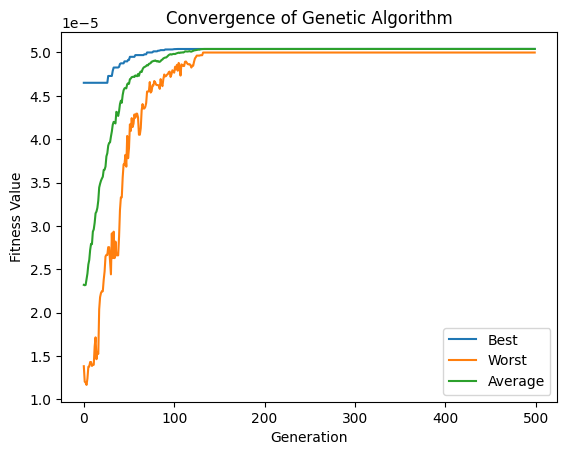

Best Total cost: 19839.0
Best Solution: [[ 8. 17. 14. 10.  8.]
 [27. 17. 21. 11. 17.]
 [ 6.  9.  8. 16. 11.]
 [15. 10.  8. 21. 21.]]


In [ ]:
# Plot best, worst, and average graphs
plt.plot(range(num_generations), best_costs, label="Best")
plt.plot(range(num_generations), worst_costs, label="Worst")
plt.plot(range(num_generations), average_costs, label="Average")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Convergence of Genetic Algorithm")
plt.legend()
plt.show()

# Find the best solution
fitness_values = fitness_evaluation(population)
best_solution_index = np.argmax(fitness_values)
best_solution = population[best_solution_index]
best_total_cost = calculate_total_cost(best_solution)

print("Best Total cost:", best_total_cost)
print("Best Solution:",best_solution )

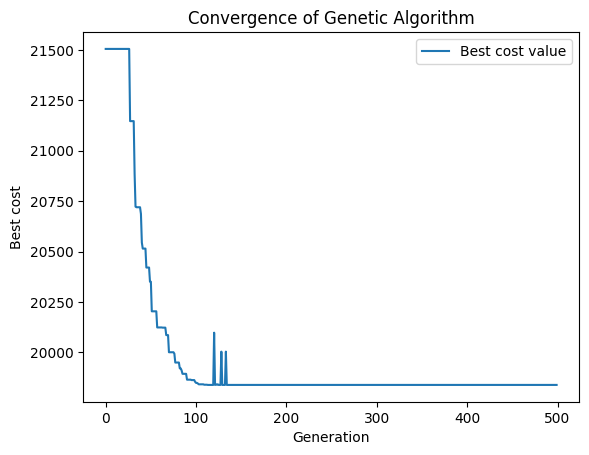

In [ ]:
# Plot best cost graph 
plt.plot(range(num_generations), best_val, label="Best cost value")
plt.xlabel("Generation")
plt.ylabel("Best cost")
plt.title("Convergence of Genetic Algorithm")
plt.legend()
plt.show()

## Problem size 5x10 

In [ ]:
#Problem parameters 5X10
num_sources = 5
num_destinations = 10

variable_costs = np.array([[8,4,3,5,2,1,3,5,2,6],[3,3,4,8,5,3,5,1,4,5],[7,4,5,3,4,2,4,3,7,3],[1,2,8,1,3,1,4,6,8,2],[4,5,6,3,3,4,2,1,2,1]])
fixed_costs = np.array([[160,488,295,376,297,360,199,292,481,162],[451,172,265,487,176,260,280,300,354,201],[167, 250, 499, 189, 340, 216, 177, 495, 170, 414],[386, 184, 370, 292, 188, 206, 340, 205, 465, 273], [156, 244, 460, 382, 270, 180, 235, 355, 276, 190]])
supply = np.array([157,293,150,575,310])
demand = np.array([225,150,90,215,130,88,57,124,273,133])

#Genetic algorithm parameters
population_size = 100
num_generations = 1000
mutation_rate = 0.4
elite_percentage = 0.2

# Initialize population
population = np.zeros((population_size, num_sources, num_destinations))
for i in range(population_size):
    remaining_supply = np.copy(supply)
    for j in range(num_destinations):
        for k in range(num_sources):
            max_allocation = min(remaining_supply[k], demand[j])
            population[i, k, j] = np.random.randint(low=0, high=max_allocation + 1)
            remaining_supply[k] -= population[i, k, j]



# Main loop
progress_bar = tqdm(total=num_generations, desc="Generations")
best_costs = []
worst_costs = []
average_costs = []
best_val = []

for generation in range(num_generations):
    fitness_values = fitness_evaluation(population)
    priority_values = priority_selection(fitness_values)
    offspring = crossover(population, priority_values)
    offspring = mutation(offspring)
    population = replacement(population, offspring, fitness_values)

    # Find the best solution
    best_solution_index = np.argmax(fitness_values)
    best_solution = population[best_solution_index]
    best_total_cost = calculate_total_cost(best_solution)

    best_val.append(best_total_cost)
    best_costs.append(np.max(fitness_values))
    worst_costs.append(np.min(fitness_values))
    average_costs.append(np.mean(fitness_values))

    progress_bar.set_postfix({"Best Total Cost": best_total_cost})
    progress_bar.update(1)

progress_bar.close()

Generations: 100%|██████████| 1000/1000 [00:39<00:00, 25.14it/s, Best Total Cost=1.77e+5]


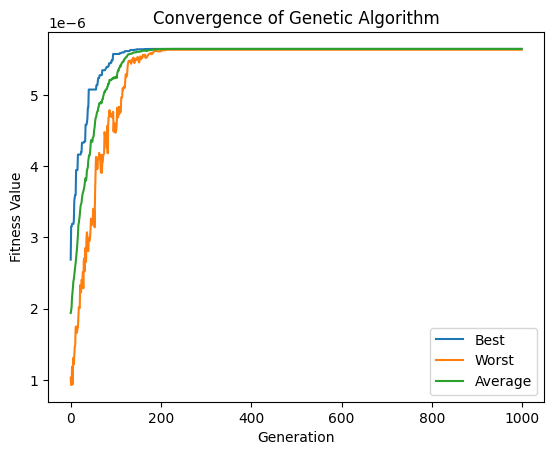

Best Total cost: 177182.0
Best Solution: [[ 10.  24.  20.   5.  38.  26.   9.   6.  19.   0.]
 [ 39.  36.  16.  22.  76.  15.  21.  42.  12.  14.]
 [ 26.  23.  22.  13.  11.  35.  13.   0.   2.   8.]
 [113.  64.  14. 116.  53.  88.  29.  24.  14.  60.]
 [ 22.  28.   8.  16.  38.  22.  23.  80.  26.  47.]]


In [ ]:
# Plot best, worst, and average graphs
plt.plot(range(num_generations), best_costs, label="Best")
plt.plot(range(num_generations), worst_costs, label="Worst")
plt.plot(range(num_generations), average_costs, label="Average")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Convergence of Genetic Algorithm")
plt.legend()
plt.show()

# Find the best solution
fitness_values = fitness_evaluation(population)
best_solution_index = np.argmax(fitness_values)
best_solution = population[best_solution_index]
best_total_cost = calculate_total_cost(best_solution)

print("Best Total cost:", best_total_cost)
print("Best Solution:",best_solution )

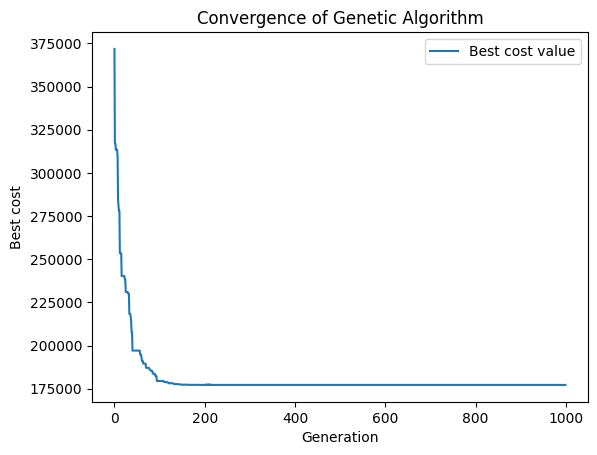

In [ ]:
# Plot best cost graph 
plt.plot(range(num_generations), best_val, label="Best cost value")
plt.xlabel("Generation")
plt.ylabel("Best cost")
plt.title("Convergence of Genetic Algorithm")
plt.legend()
plt.show()

## Working of mutation function

In [ ]:
import numpy as np

# Example values
supply = np.array([10, 15, 12])  
demand = np.array([8, 10, 15])  
num_sources = supply.shape[0]
num_destinations = demand.shape[0]
offspring = np.zeros((1, num_sources, num_destinations))  # Initial offspring allocation
def mutation(offspring):
    for i in range(offspring.shape[0]):
        remaining_supply = np.copy(supply)
        for j in range(num_destinations):
            for k in range(num_sources):
                remaining_supply[k] -= offspring[i, k, j]
        for k in range(num_sources):
            while remaining_supply[k] > 0:
                possible_destinations = np.where(demand > offspring[i, k])
                if len(possible_destinations[0]) == 0:
                    break
                dest_index = np.random.choice(possible_destinations[0])
                max_allocation = min(remaining_supply[k], demand[dest_index] - offspring[i, k, dest_index])
                allocation = np.random.randint(low=0, high=max_allocation + 1)
                offspring[i, k, dest_index] += allocation
                remaining_supply[k] -= allocation
    return offspring

# Apply mutation function
mutated_offspring = mutation(offspring)
print(mutated_offspring)


[[[ 0.  0. 10.]
  [ 8.  1.  6.]
  [ 6.  6.  0.]]]
